In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
import xgboost
from xgboost import XGBRegressor
import seaborn as sns

In [7]:
xlrd.xlsx.ensure_elementtree_imported(False, None)
xlrd.xlsx.Element_has_iter = True

data = pd.read_csv("train.csv")
target = pd.read_excel("sample_submission.xlsx")

In [8]:
target.head()

,Id,Actual_SalePrice,Linear_Regression_Predict_SalePrice,Gaussian_Process_Predict_SalePrice,Random_Forest_Predict_SalePrice,XGBoost_Predict_SalePrice,Stocked_Predict_SalePrice
0,1,208500,NaN,NaN,NaN,NaN,NaN
1,2,181500,NaN,NaN,NaN,NaN,NaN
2,3,223500,NaN,NaN,NaN,NaN,NaN
3,4,140000,NaN,NaN,NaN,NaN,NaN
4,5,250000,NaN,NaN,NaN,NaN,NaN


In [9]:
# Creating the target column in dataset
targets = target['Actual_SalePrice'].tolist()
data["SalePrice"] = targets

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

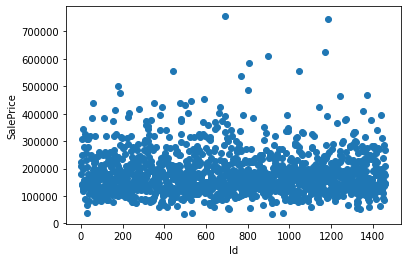

In [12]:
import matplotlib.pyplot as plt

plt.scatter(data["Id"], data["SalePrice"])
plt.xlabel("Id")
plt.ylabel("SalePrice")
plt.show()


In [6]:
# Dropping columns with mostly NAN values / useless columns

data = data.drop(["FireplaceQu","Alley","Id","Alley","PoolQC","Fence","MiscFeature"],axis = 1)
data = data.fillna(0)

In [55]:
# Correlation matrix

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.215023,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.080997,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.215023,1.000000,0.100739,0.176561,-0.053457,0.036853,0.078686,0.105010,0.076670,-0.009312,0.160829,0.238274,0.245181,0.042549,0.049981,0.220347,0.010514,-0.027856,0.120548,-0.012952,0.144494,0.034425,0.221396,0.044018,0.019317,0.165229,0.201473,-0.016780,0.069605,0.027366,0.023499,0.022969,0.114106,-0.059606,0.018942,-0.012094,0.209624
LotArea,-0.139781,0.100739,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.072599,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.176561,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.288998,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.053457,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.006515,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.036853,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.272029,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.078686,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.146357,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.023573,0.105010,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,0.388052,0.083010,0.027403,0.272999,0.199108,0.102775,-0.038450,0.279568,0.247015,0.132696,0.361945,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.069836,0.076670,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.115843,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,-0.009312,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,0.035070,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


With this we pick 20 columns with high correlation to the SalePrice and remove the rest

In [56]:
SaleCorr = corr["SalePrice"]

SaleCorr = SaleCorr.abs().sort_values(ascending=False)
print(SaleCorr[0:21])
SaleCorr = SaleCorr.reset_index()

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
GarageYrBlt     0.261366
BsmtFullBath    0.227122
Name: SalePrice, dtype: float64


In [57]:
colList = []
for i in SaleCorr["index"][0:21]:
    colList.append(i)

data = data[colList]
data

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,MasVnrArea,Fireplaces,BsmtFinSF1,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,GarageYrBlt,BsmtFullBath
0,208500,7,1710,2,548,856,856,2,8,2003,...,196.0,0,706,0,854,61,1,8450,2003.0,1
1,181500,6,1262,2,460,1262,1262,2,6,1976,...,0.0,1,978,298,0,0,0,9600,1976.0,0
2,223500,7,1786,2,608,920,920,2,6,2001,...,162.0,1,486,0,866,42,1,11250,2001.0,1
3,140000,7,1717,3,642,756,961,1,7,1915,...,0.0,1,216,0,756,35,0,9550,1998.0,1
4,250000,8,2198,3,836,1145,1145,2,9,2000,...,350.0,1,655,192,1053,84,1,14260,2000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,460,953,953,2,7,1999,...,0.0,1,0,0,694,40,1,7917,1999.0,0
1456,210000,6,2073,2,500,1542,2073,2,7,1978,...,119.0,2,790,349,0,0,0,13175,1978.0,1
1457,266500,7,2340,1,252,1152,1188,2,9,1941,...,0.0,2,275,0,1152,60,0,9042,1941.0,0
1458,142125,5,1078,1,240,1078,1078,1,5,1950,...,0.0,0,49,366,0,0,0,9717,1950.0,1


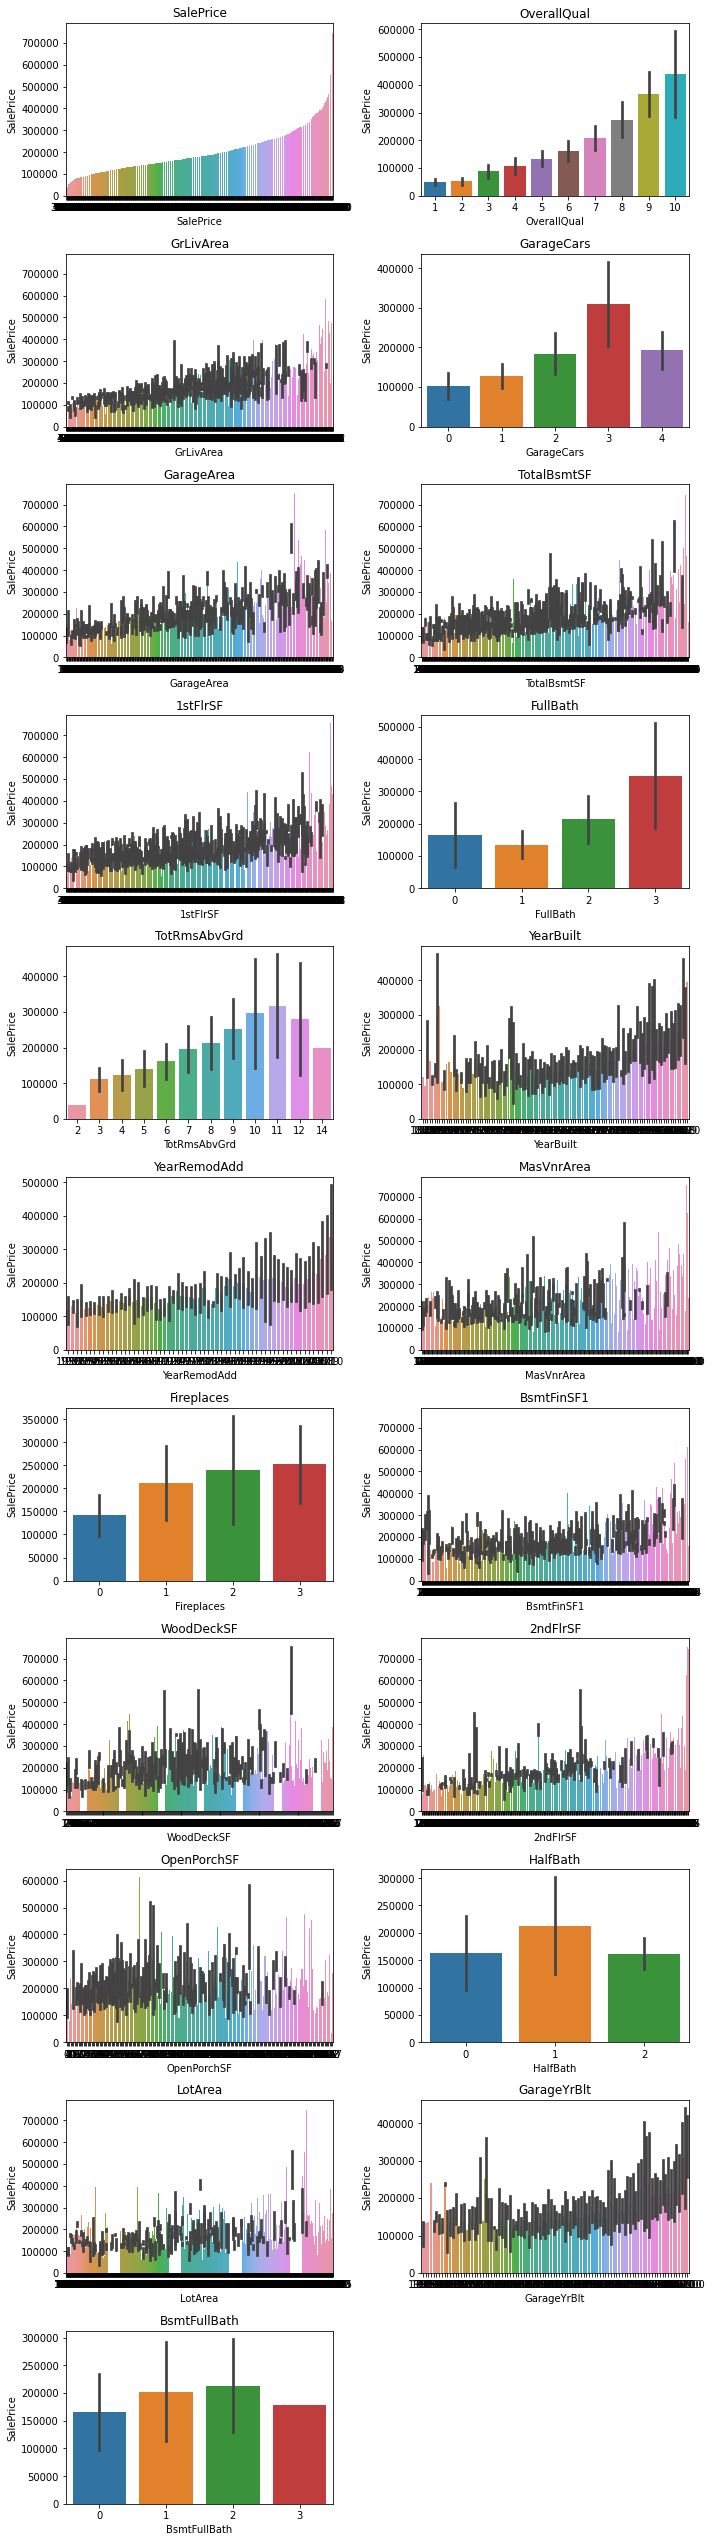

In [ ]:
fig=plt.figure(figsize=(10,160))
for i, var_name in enumerate(colList):
    ax=fig.add_subplot(50,2,i+1)
    sns.barplot(x=var_name,y='SalePrice',data=data,ci='sd')
    if var_name in ['Neighborhood','Exterior1st','Exterior2nd']:
        plt.sca(ax)
        plt.xticks(rotation=70)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

In [59]:
y=data['SalePrice']
X=data.drop('SalePrice',axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [62]:
RF = RandomForestRegressor(n_estimators=500,bootstrap=True,random_state=1,oob_score=True)
RF = RF.fit(X_train,y_train)
y_pred = RF.predict(X)

In [63]:
import math
from sklearn.metrics import mean_squared_error

num_data = X.shape[0]
mse = mean_squared_error(y, y_pred)
RMSE = math.sqrt(mse/num_data)
print(RMSE)

403.81078260666123


In [64]:
target["Random_Forest_Predict_SalePrice"] = y_pred

In [65]:
target

,Id,Actual_SalePrice,Linear_Regression_Predict_SalePrice,Gaussian_Process_Predict_SalePrice,Random_Forest_Predict_SalePrice,XGBoost_Predict_SalePrice,Stocked_Predict_SalePrice
0,1,208500,NaN,NaN,205999.986,NaN,NaN
1,2,181500,NaN,NaN,175104.738,NaN,NaN
2,3,223500,NaN,NaN,219755.952,NaN,NaN
3,4,140000,NaN,NaN,187658.874,NaN,NaN
4,5,250000,NaN,NaN,268425.568,NaN,NaN
...,...,...,...,...,...,...,...
1455,1456,175000,NaN,NaN,175358.992,NaN,NaN
1456,1457,210000,NaN,NaN,211241.552,NaN,NaN
1457,1458,266500,NaN,NaN,262879.110,NaN,NaN
1458,1459,142125,NaN,NaN,135049.400,NaN,NaN


In [66]:
lreg = LinearRegression()
lreg.fit(X_train,y_train)
mse = mean_squared_error(y, lreg.predict(X))
RMSE = math.sqrt(mse/num_data)
print(RMSE)

939.6790554728881


In [67]:
target["Linear_Regression_Predict_SalePrice"] = lreg.predict(X)
target

,Id,Actual_SalePrice,Linear_Regression_Predict_SalePrice,Gaussian_Process_Predict_SalePrice,Random_Forest_Predict_SalePrice,XGBoost_Predict_SalePrice,Stocked_Predict_SalePrice
0,1,208500,217053.621057,NaN,205999.986,NaN,NaN
1,2,181500,182114.524119,NaN,175104.738,NaN,NaN
2,3,223500,218577.296526,NaN,219755.952,NaN,NaN
3,4,140000,202465.563500,NaN,187658.874,NaN,NaN
4,5,250000,296240.549331,NaN,268425.568,NaN,NaN
...,...,...,...,...,...,...,...
1455,1456,175000,180841.189668,NaN,175358.992,NaN,NaN
1456,1457,210000,238101.628086,NaN,211241.552,NaN,NaN
1457,1458,266500,215273.952726,NaN,262879.110,NaN,NaN
1458,1459,142125,128001.884366,NaN,135049.400,NaN,NaN


In [68]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


In [69]:
kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel,random_state=42)
gp.fit(X_train, y_train)
mse = mean_squared_error(y, gp.predict(X))
RMSE = math.sqrt(mse/num_data)
print(RMSE)

1054.74356190732


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [70]:
target["Gaussian_Process_Predict_SalePrice"] = gp.predict(X)
target

,Id,Actual_SalePrice,Linear_Regression_Predict_SalePrice,Gaussian_Process_Predict_SalePrice,Random_Forest_Predict_SalePrice,XGBoost_Predict_SalePrice,Stocked_Predict_SalePrice
0,1,208500,217053.621057,214408.818249,205999.986,NaN,NaN
1,2,181500,182114.524119,173604.982277,175104.738,NaN,NaN
2,3,223500,218577.296526,220581.842934,219755.952,NaN,NaN
3,4,140000,202465.563500,154149.075745,187658.874,NaN,NaN
4,5,250000,296240.549331,282317.284721,268425.568,NaN,NaN
...,...,...,...,...,...,...,...
1455,1456,175000,180841.189668,190387.686497,175358.992,NaN,NaN
1456,1457,210000,238101.628086,246512.007500,211241.552,NaN,NaN
1457,1458,266500,215273.952726,206828.594635,262879.110,NaN,NaN
1458,1459,142125,128001.884366,139697.125969,135049.400,NaN,NaN


In [71]:
xg_reg = XGBRegressor(max_depth=5, n_estimators=10)
xg_reg.fit(X_train,y_train)
mse = mean_squared_error(y, xg_reg.predict(X))
RMSE = math.sqrt(mse/num_data)
print(RMSE)

[15:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1984.8613427728646


In [72]:
target["XGBoost_Predict_SalePrice"] = xg_reg.predict(X)
target

,Id,Actual_SalePrice,Linear_Regression_Predict_SalePrice,Gaussian_Process_Predict_SalePrice,Random_Forest_Predict_SalePrice,XGBoost_Predict_SalePrice,Stocked_Predict_SalePrice
0,1,208500,217053.621057,214408.818249,205999.986,123578.203125,NaN
1,2,181500,182114.524119,173604.982277,175104.738,103755.515625,NaN
2,3,223500,218577.296526,220581.842934,219755.952,136621.093750,NaN
3,4,140000,202465.563500,154149.075745,187658.874,110369.656250,NaN
4,5,250000,296240.549331,282317.284721,268425.568,193583.406250,NaN
...,...,...,...,...,...,...,...
1455,1456,175000,180841.189668,190387.686497,175358.992,115074.898438,NaN
1456,1457,210000,238101.628086,246512.007500,211241.552,138064.406250,NaN
1457,1458,266500,215273.952726,206828.594635,262879.110,156399.625000,NaN
1458,1459,142125,128001.884366,139697.125969,135049.400,82623.070312,NaN


In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingRegressor

In [75]:
def get_stacking():
    # define the base models
    level0 = list()
    #level0.append(('lr', LinearRegression()))
    level0.append(('gp', GaussianProcessRegressor(kernel=kernel,random_state=42)))
    level0.append(('rc', RandomForestRegressor(n_estimators=500,bootstrap=True,random_state=1,oob_score=True)))
    level0.append(('xgb', XGBRegressor(max_depth=5, n_estimators=10)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
stacked = get_stacking()
stacked.fit(X_test, y_test)
y_pred = stacked.predict(X)

In [77]:
num_data = X.shape[0]
mse = mean_squared_error(y, y_pred)
RMSE = math.sqrt(mse/num_data)
print(RMSE)

823.7815744511447


In [78]:
target["Stocked_Predict_SalePrice"] = y_pred
target

,Id,Actual_SalePrice,Linear_Regression_Predict_SalePrice,Gaussian_Process_Predict_SalePrice,Random_Forest_Predict_SalePrice,XGBoost_Predict_SalePrice,Stocked_Predict_SalePrice
0,1,208500,217053.621057,214408.818249,205999.986,123578.203125,217693.585128
1,2,181500,182114.524119,173604.982277,175104.738,103755.515625,168198.578803
2,3,223500,218577.296526,220581.842934,219755.952,136621.093750,218854.410284
3,4,140000,202465.563500,154149.075745,187658.874,110369.656250,145783.438942
4,5,250000,296240.549331,282317.284721,268425.568,193583.406250,327167.521204
...,...,...,...,...,...,...,...
1455,1456,175000,180841.189668,190387.686497,175358.992,115074.898438,172509.544757
1456,1457,210000,238101.628086,246512.007500,211241.552,138064.406250,208968.370438
1457,1458,266500,215273.952726,206828.594635,262879.110,156399.625000,239542.624916
1458,1459,142125,128001.884366,139697.125969,135049.400,82623.070312,116166.109980


In [ ]:
from google.colab import files
target.to_csv("Submission.csv")
files.download("Submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>